# DATASET

The dataset is taken from **Kaggle** and the link is shared below. The title is 'Brooklyn Home Sales, 2003 to 2017'.

Size of the dataset - 391k * 111

link - https://www.kaggle.com/tianhwu/brooklynhomes2003to2017

# MEMBERS

Max Gerstman

Geetika Bhati

Manish Dalal

# REQUIREMENTS ( Packages with versions )

**Pyspark is used to execute this notebook** - It is integration of python with spark framework.

To install package - pip install 'package name'

Spark - 2.3.1

Python - Version > 3

Numpy - 1.15.4

Pandas - 0.23.4

Matplotlib - 3.0.2

Seaborn - 0.9.0



# INSTALLATION

No need to install any other packages apart from the ones listed below.

Just make sure that you have python version > 3 installed on your machine.

Run the spark session from the code cell below

# FITTED MODELS

**Regression Model** - Use this line - from pyspark.ml import feature, regression, evaluation, Pipeline

Four regression models are fitted with different set of input features to create the best model

RMSE is used as a parameter to get the best model

# IMPORTING PACKAGES

In [1]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


# INITIATE SPARK SESSION

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

**Load the dataset and print the schema**

In [3]:
df = spark.read.option('header','true').option('inferSchema','true').csv('brooklyn_sales_map.csv')

In [4]:
print(df.printSchema())

root
 |-- _c0: integer (nullable = true)
 |-- borough1: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- building_class_category: string (nullable = true)
 |-- tax_class: string (nullable = true)
 |-- block: integer (nullable = true)
 |-- lot: integer (nullable = true)
 |-- easement: string (nullable = true)
 |-- building_class: string (nullable = true)
 |-- address9: string (nullable = true)
 |-- apartment_number: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- residential_units: integer (nullable = true)
 |-- commercial_units: integer (nullable = true)
 |-- total_units: integer (nullable = true)
 |-- land_sqft: decimal(10,0) (nullable = true)
 |-- gross_sqft: decimal(10,0) (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- tax_class_at_sale: integer (nullable = true)
 |-- building_class_at_sale: string (nullable = true)
 |-- sale_price: decimal(10,0) (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- year

# DATA EXPLORATION AND DESCRIPTIVE STATISTICS

In [5]:
df = df.where(fn.col('sale_price')> 50000)  # Selecting rows where the sale price is greater than 50000
df = df.where(fn.col('sale_price') <= 14425000) # Selecting rows where the sale price is less than= 14425000
df = df.where(fn.col('neighborhood') != '3004')# Removing outlier

In [6]:
sale_price = df.select('sale_price').toPandas()
neighborhoods = df.select('neighborhood').toPandas()

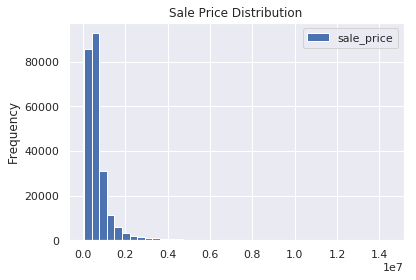

In [7]:
sale_price = df.select('sale_price').toPandas()

sale_price = sale_price.astype('float')
sale_price.plot(kind='hist', bins=40)
plt.title('Sale Price Distribution')
plt.show()

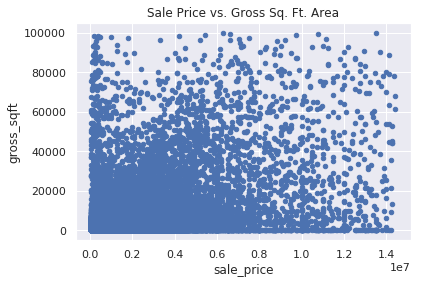

In [8]:
sqft_sale = df.select('sale_price', 'gross_sqft').toPandas()
sqft_sale['sale_price'] = sqft_sale['sale_price'].astype('float')
sqft_sale['gross_sqft'] = sqft_sale['gross_sqft'].astype('float')

#take out positive outliers
sqft_sale = sqft_sale[sqft_sale['gross_sqft'] < 100000]

sqft_sale.plot(x = 'sale_price', y= 'gross_sqft', kind = 'scatter')
plt.title('Sale Price vs. Gross Sq. Ft. Area')
plt.show()

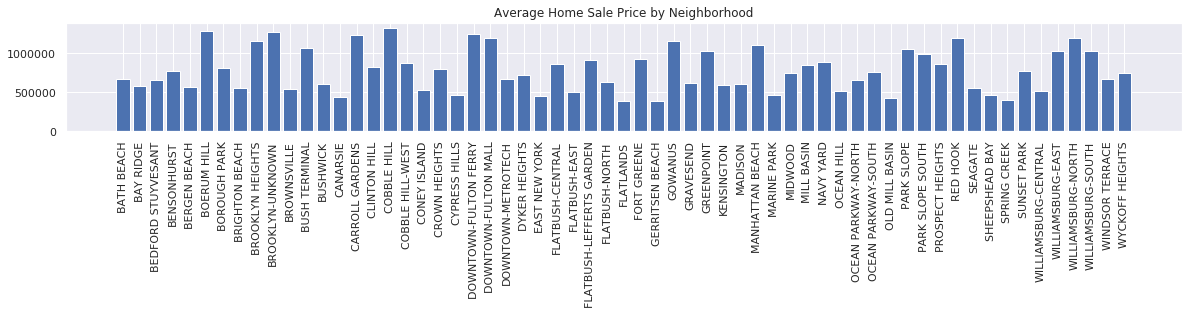

In [9]:
neighborhood_sale = df.select('neighborhood', 'sale_price').toPandas()
neighborhood_sale['sale_price'] = neighborhood_sale['sale_price'].astype('int')
neighborhood_sale = neighborhood_sale[neighborhood_sale['neighborhood'] != 'JAMAICA BAY']

ns = neighborhood_sale.groupby(by = 'neighborhood').mean()


fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.bar(ns.index, ns['sale_price'])
plt.xticks(rotation= 90)
plt.title('Average Home Sale Price by Neighborhood')
import pylab
pylab.savefig('brooklyn_bar.png')
plt.show()

# DATA CLEANING

**Removing NA's**

**Casting columns to required data type**


In [10]:
df = df.withColumn("tax_class_at_sale", df["tax_class_at_sale"].cast(StringType()))

In [11]:
cols = [ 'RetailArea','StrgeArea','ProxCode','ExemptLand','borough1','zip_code', 'total_units',
                     'ExemptTot','YearAlter1','BuiltFar','block', 'lot', 'residential_units','commercial_units',
              'sale_price', 'gross_sqft', 'land_sqft', 'year_built', 'year_of_sale','building_class','tax_class_at_sale']

df = df.na.replace('NA','0')
df = df.replace('None','0')
df = df.dropna(subset=cols)



# ONE HOT ENCODING

**Converting string features to numeric and then applying one hot encoding**

In [12]:

indexer = StringIndexer(inputCol="neighborhood", outputCol="neighborhood_numeric").fit(df)
indexed_df = indexer.transform(df)


indexer1 = StringIndexer(inputCol="HistDist", outputCol="HistDist_numeric").fit(df)
indexed_df1 = indexer1.transform(df)

indexer2 = StringIndexer(inputCol="building_class", outputCol="building_class_numeric").fit(df)
indexed_df2 = indexer2.transform(df)


indexer3 = StringIndexer(inputCol="tax_class_at_sale", outputCol="tax_class_at_sale_numeric").fit(df)
indexed_df3 = indexer3.transform(df)

# One hot encoding

encoder = OneHotEncoder(inputCol="neighborhood_numeric", outputCol="neighborhood_vector")
encoded_df = encoder.transform(indexed_df)


encoder1 = OneHotEncoder(inputCol="HistDist_numeric", outputCol="HistDist_vector")
encoded_df1 = encoder1.transform(indexed_df1)

encoder2 = OneHotEncoder(inputCol="building_class_numeric", outputCol="building_class_vector")
encoded_df2 = encoder2.transform(indexed_df2)

encoder3 = OneHotEncoder(inputCol="tax_class_at_sale_numeric", outputCol="tax_class_at_sale_vector")
encoded_df3 = encoder3.transform(indexed_df3)

encoder_df = encoded_df.select('neighborhood_vector')
encoder_df1 = encoded_df1.select('HistDist_vector')
encoder_df2 = encoded_df2.select('building_class_vector')
encoder_df3 = encoded_df3.select('tax_class_at_sale_vector')


**Using SQL join to combine different dataframes created above to one final dataframe**

**Using monotonically_increasing_id() to apply JOIN**

In [13]:
from pyspark.sql import functions as fn
df = df.withColumn("idx", fn.monotonically_increasing_id())

encoder_df=encoder_df.withColumn("idx", fn.monotonically_increasing_id())

encoder_df1=encoder_df1.withColumn("idx", fn.monotonically_increasing_id())

encoder_df2=encoder_df2.withColumn("idx", fn.monotonically_increasing_id())

encoder_df3=encoder_df3.withColumn("idx", fn.monotonically_increasing_id())

df = df.join(encoder_df, df.idx ==encoder_df.idx )
df = df.drop('idx')

df = df.withColumn("idx", fn.monotonically_increasing_id())
df = df.join(encoder_df1, df.idx ==encoder_df1.idx )
df = df.drop('idx')

df = df.withColumn("idx", fn.monotonically_increasing_id())
df = df.join(encoder_df2, df.idx ==encoder_df2.idx )
df = df.drop('idx')

df = df.withColumn("idx", fn.monotonically_increasing_id())
df = df.join(encoder_df3, df.idx ==encoder_df3.idx )
df = df.drop('idx')

# TYPE CASTING

**Converting following columns to Integer Type - So that we can apply scaling and then create a model**

**Printing Schema to verify the cast result**

In [14]:

df = df.withColumn("RetailArea", df["RetailArea"].cast(IntegerType()))
df = df.withColumn("StrgeArea", df["StrgeArea"].cast(IntegerType()))
df = df.withColumn("ProxCode", df["ProxCode"].cast(IntegerType()))

df = df.withColumn("ExemptLand", df["ExemptLand"].cast(IntegerType()))
df = df.withColumn("ExemptTot", df["ExemptTot"].cast(IntegerType()))
df = df.withColumn("YearAlter1", df["YearAlter1"].cast(IntegerType()))
df = df.withColumn("BuiltFar", df["BuiltFar"].cast(IntegerType()))

df = df.withColumn("gross_sqft", df["gross_sqft"].cast(IntegerType()))
df = df.withColumn("land_sqft", df["land_sqft"].cast(IntegerType()))
df = df.withColumn("year_built", df["year_built"].cast(IntegerType()))
df = df.withColumn("year_of_sale", df["year_of_sale"].cast(IntegerType()))

In [15]:
print(df.printSchema())

root
 |-- _c0: integer (nullable = true)
 |-- borough1: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- building_class_category: string (nullable = true)
 |-- tax_class: string (nullable = true)
 |-- block: integer (nullable = true)
 |-- lot: integer (nullable = true)
 |-- easement: string (nullable = true)
 |-- building_class: string (nullable = true)
 |-- address9: string (nullable = true)
 |-- apartment_number: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- residential_units: integer (nullable = true)
 |-- commercial_units: integer (nullable = true)
 |-- total_units: integer (nullable = true)
 |-- land_sqft: integer (nullable = true)
 |-- gross_sqft: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- tax_class_at_sale: string (nullable = true)
 |-- building_class_at_sale: string (nullable = true)
 |-- sale_price: decimal(10,0) (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- year_of_sale: int

# SAMPLING - Creating Test Splits

**Splitting the dataset into 3 parts training(60%), validation(30%) and testing(10%)**

In [16]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1], seed=0)

# CREATING PIPELINES

**stage1- Vector assembling**

**stage2- Standard scaling**


In [17]:
Pipeline1 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=[ 'gross_sqft', 'land_sqft', 'year_built', 'year_of_sale','block', 'lot', 'total_units','residential_units','commercial_units'],
                           outputCol='features'),
    
    feature.StandardScaler(withStd=False,
                           inputCol='features', outputCol='zfeatures1')]).fit(df)

In [18]:
Pipeline2 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=[ 'neighborhood_vector','gross_sqft', 'land_sqft', 'year_built', 'year_of_sale','block', 'lot', 'total_units','residential_units','commercial_units'],
                           outputCol='features'),
    
    feature.StandardScaler(withStd=False,
                           inputCol='features', outputCol='zfeatures2')]).fit(df)

In [19]:
Pipeline3 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['block', 'lot', 'residential_units','commercial_units', 'RetailArea',
            'StrgeArea','ProxCode','ExemptLand','ExemptTot','YearAlter1','BuiltFar','neighborhood_vector','HistDist_vector'],
              outputCol='features'),
    feature.StandardScaler(withStd=False,
                           inputCol='features', outputCol='zfeatures3')]).fit(df)

In [20]:
Pipeline4 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['RetailArea','StrgeArea','ProxCode','ExemptLand',
                     'ExemptTot','YearAlter1','BuiltFar','block', 'lot', 'residential_units','commercial_units',
               'gross_sqft', 'land_sqft', 'year_built', 'year_of_sale',
              'neighborhood_vector','HistDist_vector','building_class_vector','tax_class_at_sale_vector'],
                             outputCol='features'),
    
    feature.StandardScaler(withStd=False,
                           inputCol='features', outputCol='zfeatures4')]).fit(df)

# FITTING MODELS

**Regression Models**

**Features - generated above by the 4 pipelines**

**Label - sale_price**

In [21]:
lr1= regression.LinearRegression(featuresCol='zfeatures1', labelCol='sale_price')

In [22]:
lr2= regression.LinearRegression(featuresCol='zfeatures2', labelCol='sale_price')

In [23]:
lr3= regression.LinearRegression(featuresCol='zfeatures3', labelCol='sale_price')

In [24]:
lr4= regression.LinearRegression(featuresCol='zfeatures4', labelCol='sale_price')

In [25]:
pipeline_lr1 = Pipeline(stages=[Pipeline1,lr1])

model1 = pipeline_lr1.fit(training_df)

In [26]:
pipeline_lr2 = Pipeline(stages=[Pipeline2,lr2])

model2 = pipeline_lr2.fit(training_df)

In [27]:
pipeline_lr3 = Pipeline(stages=[Pipeline3,lr3])

model3 = pipeline_lr3.fit(training_df)

In [28]:
pipeline_lr4 = Pipeline(stages=[Pipeline4,lr4])

model4 = pipeline_lr4.fit(training_df)

# GENERALISATION

**transforming the fitted models on validation set and then calculating the lowest model RMSE on the test set**

In [29]:
# Make predictions.
predictions1 = model1.transform(validation_df)

predictions2 = model2.transform(validation_df)

predictions3 = model3.transform(validation_df)

predictions4 = model4.transform(validation_df)

# CALCULATE RMSE - VALIDATION SET


In [30]:

mse = fn.mean((fn.col('sale_price') - fn.col('prediction'))**2).alias('mse')
rmse = sqrt(mse)

print('Model 1 - RMSE')
model1.transform(validation_df).select(rmse).show()

print('Model 2 - RMSE')
model2.transform(validation_df).select(rmse).show()

print('Model 3 - RMSE')
model3.transform(validation_df).select(rmse).show()

print('Model 4 - RMSE')
model4.transform(validation_df).select(rmse).show()

Model 1 - RMSE
+-------------------------------------------------------+
|SQRT(avg(POWER((sale_price - prediction), 2)) AS `mse`)|
+-------------------------------------------------------+
|                                      841982.7225376875|
+-------------------------------------------------------+

Model 2 - RMSE
+-------------------------------------------------------+
|SQRT(avg(POWER((sale_price - prediction), 2)) AS `mse`)|
+-------------------------------------------------------+
|                                       821859.499182439|
+-------------------------------------------------------+

Model 3 - RMSE
+-------------------------------------------------------+
|SQRT(avg(POWER((sale_price - prediction), 2)) AS `mse`)|
+-------------------------------------------------------+
|                                      871714.8577946433|
+-------------------------------------------------------+

Model 4 - RMSE
+-------------------------------------------------------+
|SQRT(avg

# CALCULATE RMSE for the best model so far - TEST SET

In [31]:
model4.transform(testing_df).select(rmse).show() # best model

+-------------------------------------------------------+
|SQRT(avg(POWER((sale_price - prediction), 2)) AS `mse`)|
+-------------------------------------------------------+
|                                      721667.1557282272|
+-------------------------------------------------------+



# PRINT COEFFICIENTS AND INTERCEPT FOR THE BEST MODEL

In [32]:
print(model4.stages[-1].coefficients)
print(model4.stages[-1].intercept)

[53.39489829640317,0.3359297617966068,-15439.597234871168,-0.07930629884127874,0.016182086701890946,34.13915230025102,13634.41869129464,17.669645827888882,90.21048644925759,169.50132446483005,38592.714126976345,8.03006542712752,16.38234689576356,8.489952586101458,41122.74602876816,-1875760.6805362294,-2085615.8180195158,-1685035.836424141,-1992398.353327278,-1740122.8343524777,-1165886.7981119999,-2073896.9981284307,-1838250.479005901,-1798516.989673861,-2026780.660221137,-1873888.6345046272,-1724253.5948887495,-1753452.8198705511,-1677695.6365681123,-2020097.6150297825,-1769550.6159479904,-1053788.7031492435,-1751590.42692453,-1706895.7774222533,-2064587.020432294,-1557292.478393868,-1247350.388043273,-1551083.8376124732,-1495115.3032635383,-1997746.4105519284,-1818230.079721739,-1322755.187666005,-1639331.130327439,-1969970.9359950523,-1786941.337432396,-1778890.2428351762,-1416928.1904097474,-1363109.4217749191,-2048989.2051643727,-2001072.4215702056,-2095237.959577065,-972019.41740

# SHOW PREDICTIONS

In [33]:
# Select example rows to display.
pred1 = predictions1.select("zfeatures1","sale_price","prediction")
pred2 = predictions2.select("zfeatures2","sale_price","prediction")
pred3 = predictions3.select("zfeatures3","sale_price","prediction")
pred4 = predictions4.select("zfeatures4","sale_price","prediction")

**Coverting predicted dataframes to pandas dataframes**

In [34]:
df_pred1 = pred1.toPandas()
df_pred2 = pred2.toPandas()
df_pred3 = pred3.toPandas()
df_pred4 = pred4.toPandas()

# PLOTTING PREDICTIONS - Actual vs Predicted

**scatter plot**

**red dots - predicted, blue dots - actual sale price**

**scale - xaxis = predicted sale price, yaxis = actual sale price**


# MODEL 1

In [35]:
pred1.show(5)

+--------------------+----------+------------------+
|          zfeatures1|sale_price|        prediction|
+--------------------+----------+------------------+
|[61600.0,20000.0,...|  14416220| 2660460.514698684|
|[135505.0,42000.0...|  14325679|  4346857.20256038|
|[13390.0,6695.0,1...|  14250000|1845244.3039780557|
|[44400.0,9547.0,1...|  14250000|1848965.5320236683|
|[104348.0,24400.0...|  14050000|3309849.5647078305|
+--------------------+----------+------------------+
only showing top 5 rows



<function matplotlib.pyplot.show(*args, **kw)>

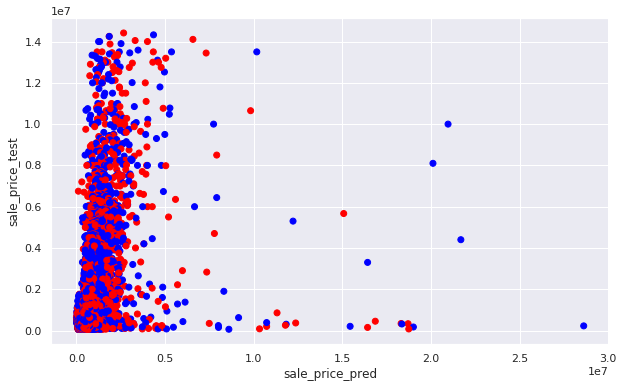

In [36]:
Ypred = df_pred1['prediction']
Ytest = df_pred1['sale_price']
colors=('red','blue')

plt.figure(figsize=(10,6))
plt.scatter(Ypred,Ytest,c=colors)

plt.xlabel('sale_price_pred')
plt.ylabel('sale_price_test')
plt.show

# MODEL 2

In [37]:
pred2.show(5)

+--------------------+----------+------------------+
|          zfeatures2|sale_price|        prediction|
+--------------------+----------+------------------+
|(70,[28,61,62,63,...|  14416220| 2547183.057807833|
|(70,[28,61,62,63,...|  14325679| 4274104.405780971|
|(70,[31,61,62,63,...|  14250000|1992726.5501556993|
|(70,[17,61,62,63,...|  14250000|2103127.9331938475|
|(70,[18,61,62,63,...|  14050000| 3482928.950331703|
+--------------------+----------+------------------+
only showing top 5 rows



<function matplotlib.pyplot.show(*args, **kw)>

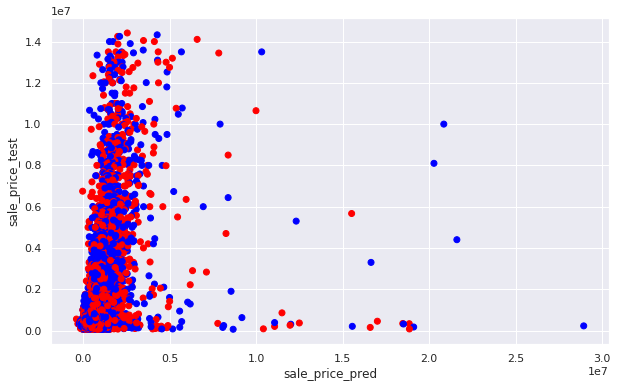

In [38]:
Ypred = df_pred2['prediction']
Ytest = df_pred2['sale_price']
colors=('red','blue')

plt.figure(figsize=(10,6))
plt.scatter(Ypred,Ytest,c=colors)

#xlim(1, 50)

plt.xlabel('sale_price_pred')
plt.ylabel('sale_price_test')
plt.show

# MODEL 3

In [39]:
pred3.show(5)

+--------------------+----------+------------------+
|          zfeatures3|sale_price|        prediction|
+--------------------+----------+------------------+
|(107,[0,1,2,9,10,...|  14416220| 711628.3048730381|
|(107,[0,1,2,10,39...|  14325679| 649584.9474241585|
|(107,[0,1,3,42,72...|  14250000|1601602.4115991704|
|(107,[0,1,2,8,9,1...|  14250000|1047936.3072189577|
|(107,[0,1,2,10,29...|  14050000| 767783.3698436096|
+--------------------+----------+------------------+
only showing top 5 rows



<function matplotlib.pyplot.show(*args, **kw)>

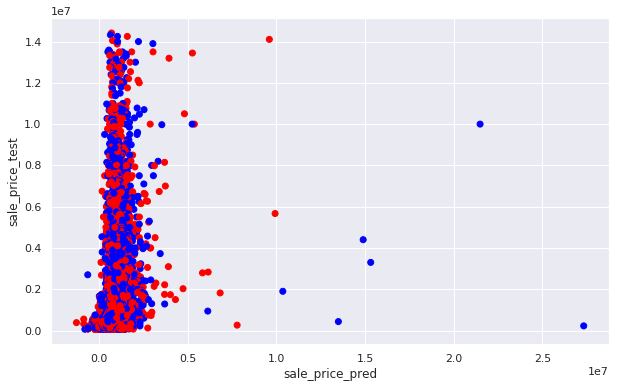

In [40]:
Ypred = df_pred3['prediction']
Ytest = df_pred3['sale_price']
colors=('red','blue')

plt.figure(figsize=(10,6))
plt.scatter(Ypred,Ytest,c=colors)

#xlim(1, 50)

plt.xlabel('sale_price_pred')
plt.ylabel('sale_price_test')
plt.show

# MODEL 4 - Best Model

In [41]:
pred4.show(5)

+--------------------+----------+------------------+
|          zfeatures4|sale_price|        prediction|
+--------------------+----------+------------------+
|(283,[5,6,7,8,9,1...|  14416220| 5069866.414391667|
|(283,[6,7,8,9,11,...|  14325679| 5597197.044600353|
|(283,[7,8,10,11,1...|  14250000|2244573.6485642344|
|(283,[4,5,6,7,8,9...|  14250000| 5083409.259398326|
|(283,[6,7,8,9,11,...|  14050000| 5489511.034885734|
+--------------------+----------+------------------+
only showing top 5 rows



<function matplotlib.pyplot.show(*args, **kw)>

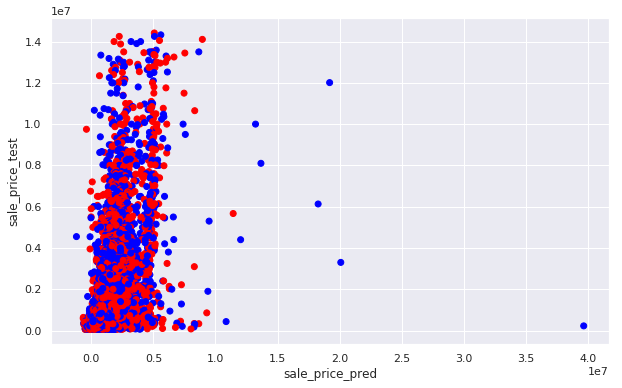

In [42]:
Ypred = df_pred4['prediction']
Ytest = df_pred4['sale_price']
colors=('red','blue')

plt.figure(figsize=(10,6))
plt.scatter(Ypred,Ytest,c=colors)

#xlim(1, 50)

plt.xlabel('sale_price_pred')
plt.ylabel('sale_price_test')
plt.show

# PLOTTING RMSE for all the models

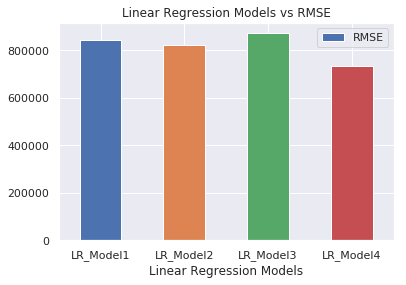

In [43]:
import pandas as pd
df_rmse = pd.DataFrame({'Linear Regression Models':['LR_Model1', 'LR_Model2', 'LR_Model3','LR_Model4'], 'RMSE':[841982.7225376875,821859.499182439,871714.8577946433,732417.5763206462]})
ax = df_rmse.plot.bar(x='Linear Regression Models', y='RMSE', rot=0,title='Linear Regression Models vs RMSE')

# DEMO 

**Enter your own values to preict the sale price - Steps below shows the predicted price for model 1**

In [46]:
sample = [Row(gross_sqft = 3465000, land_sqft= 3000, year_built = 2000,
              year_of_sale= 2014, block = 120, lot =1, total_units = 4, residential_units=4, commercial_units=0,sale_price = '')]
sample_df=spark.createDataFrame(sample)

In [47]:
predictions5 = model1.transform(sample_df)

In [56]:
predictions5.select("zfeatures1","sale_price","prediction")

DataFrame[zfeatures1: vector, sale_price: string, prediction: double]